In [349]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

In [350]:

# On charge les données
data = pd.read_csv("data/dataset.csv")
texts = data["description_irm"].dropna().tolist()

In [351]:

# On vectorise TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(texts)

In [352]:

# DBSCAN
dbscan = DBSCAN(eps=0.77, min_samples=3)
dbscan.fit(vectors)
cluster_labels = dbscan.labels_


In [353]:

# Statistiques
no_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
no_noise = list(cluster_labels).count(-1)
print(f"Nombre estimé de clusters : {no_clusters}")
print(f"Nombre de points de bruit : {no_noise}")

Nombre estimé de clusters : 5
Nombre de points de bruit : 53


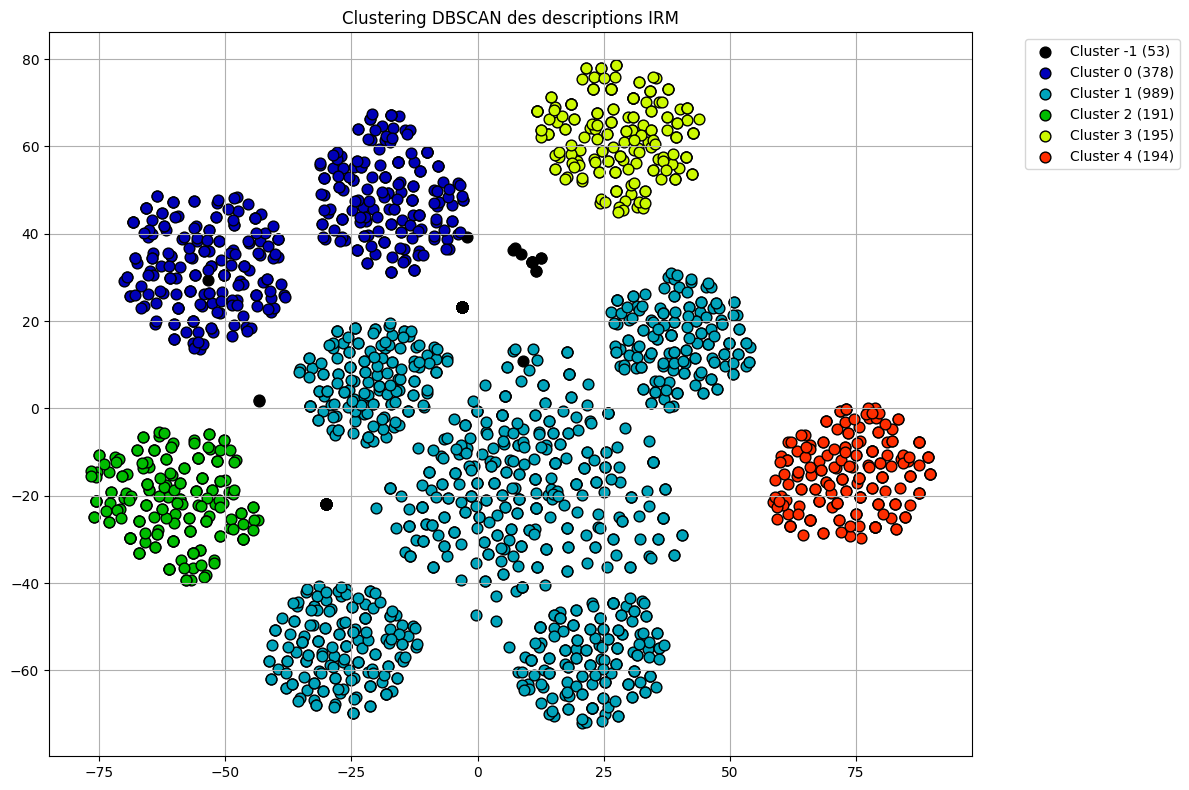

In [354]:

# t-SNE pour une meilleure visualisation
coords_2d = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(vectors.toarray())

# Couleurs
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
cmap = matplotlib.colormaps.get_cmap('nipy_spectral')
colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

# Affichage
plt.figure(figsize=(12, 8))
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    mask = cluster_labels == label
    plt.scatter(coords_2d[mask, 0], coords_2d[mask, 1],
                c=[colors[i]], label=f"Cluster {label} ({count})",
                s=60, edgecolor='k')

plt.title("Clustering DBSCAN des descriptions IRM")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C'est bien beau tout ça mais **comment déterminer la valeur d'Epsilon ?**

## k-distance graph (pour déterminer eps)

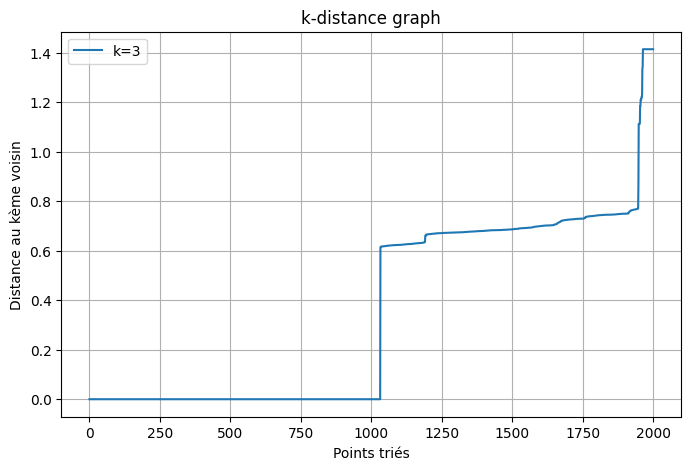

In [355]:

plt.figure(figsize=(8, 5))

k = 3 # correspond à la valeur de min_sample
nbrs = NearestNeighbors(n_neighbors=k).fit(vectors)
distances, _ = nbrs.kneighbors(vectors)
k_distances = np.sort(distances[:, -1])
plt.plot(k_distances, label=f"k={k}")

plt.title("k-distance graph")
plt.xlabel("Points triés")
plt.ylabel("Distance au kème voisin")
plt.legend()
plt.grid(True)
plt.show()


Sur ce graphique, la première partie plate indique un groupe de points très denses et donc très proches les uns des autres. Cela correspond aix descriptions IRM redondantes ou très similaires.

Le premier coude vers 0.6 marque la transition vers des points plus dispersés, des descriptions moins fréquentes.

**Le second coude et donc le dernier correspond à des points beaucoup plus isolés qui nous intéressent : ce sont les valeurs aberrantes, les titres de films que nous avons volontairement injectés dans le dataset.**



## Vérifions que les outliers correspondent aux titres de films

In [356]:
bruit = data[cluster_labels == -1]
print("\n--- Valeurs détectées comme bruit ---")
display(bruit["description_irm"])



--- Valeurs détectées comme bruit ---


107     Coupes CISSOR d'Edward aux Mains d'Argent
108          Coupe DWI JAUNE PIPI de Donald TRUMP
115                 Étude FLAIR du Pelvis Presley
1950                                 Blade Runner
1951                            Star Wars: Empire
1952                                    Inception
1953                                 Interstellar
1954                                   The Matrix
1955                  2001: L’Odyssée de l’espace
1956                                      Arrival
1957                                   Ex Machina
1958                                   District 9
1959                              Minority Report
1960                           Ghost in the Shell
1961                               The Terminator
1962                                         Dune
1963                             Edge of Tomorrow
1964                                     Sunshine
1965                             Ready Player One
1966                                  Snowpiercer


Mais... On a 53 outliers détectés alors qu'on a inséré 50 titres de films ! En effet, je me suis permis de modifier trois descriptions pour compliquer un peu la clusterisation 😉 :
**
- Coupes CISSOR d'Edward aux Mains d'Argent
- Coupe DWI JAUNE PIPI de Donald TRUMP
- Étude FLAIR du Pelvis Presley**

Ces trois valeurs contiennent des mots-clés tels que "Coupe", "DWI", "FLAIR". Elles partagent tout de même une similarité avec les autres valeurs. On a peut-être pas forcément envie que ce soit des outliers. Admettons qu'on souhaite les clusteriser.

J'ai varié précisément Epsilon pour les inclure mais cela a eu pour effet d'exclure d'autres valeurs des clusters. Alors, comment faire ?
Essayons une autre approche...

On va mesurer leur distance minimale par rapport aux clusters et on va fixer un seuil. Si leur distance est en dessous de ce seuil, on les clusterise dans un nouveau cluster. 

In [357]:

X = vectors.toarray()

# 4. Détection automatique des "faux bruités"
mask_bruit = cluster_labels == -1
mask_clusters = cluster_labels != -1

X_bruit = X[mask_bruit]
X_clusters = X[mask_clusters]
indices_bruit = np.where(mask_bruit)[0]


# Calculons la distance minimale vers les clusters
distances = cosine_distances(X_bruit, X_clusters)
min_distances = distances.min(axis=1)
SEUIL = 0.91 # A déterminer selon les résultats
indices_recuperables = [indices_bruit[i] for i, d in enumerate(min_distances) if d < SEUIL]

# Pour vérifier
for i, idx in enumerate(indices_bruit):
    desc = data.iloc[idx]["description_irm"]
    print(f"{desc[:60]}... → distance min = {min_distances[i]:.3f}")

Coupes CISSOR d'Edward aux Mains d'Argent... → distance min = 0.900
Coupe DWI JAUNE PIPI de Donald TRUMP... → distance min = 0.896
Étude FLAIR du Pelvis Presley... → distance min = 0.380
Blade Runner... → distance min = 0.756
Star Wars: Empire... → distance min = 1.000
Inception... → distance min = 1.000
Interstellar... → distance min = 1.000
The Matrix... → distance min = 1.000
2001: L’Odyssée de l’espace... → distance min = 1.000
Arrival... → distance min = 1.000
Ex Machina... → distance min = 1.000
District 9... → distance min = 1.000
Minority Report... → distance min = 1.000
Ghost in the Shell... → distance min = 1.000
The Terminator... → distance min = 1.000
Dune... → distance min = 1.000
Edge of Tomorrow... → distance min = 1.000
Sunshine... → distance min = 1.000
Ready Player One... → distance min = 1.000
Snowpiercer... → distance min = 1.000
Moon... → distance min = 1.000
Gattaca... → distance min = 1.000
Annihilation... → distance min = 1.000
The Fifth Element... → distance mi

On voit que nos 3 descriptions ont des valeurs intéressantes dans leurs distances minimales par rapport aux vrais "outliers" :
- Coupes CISSOR d'Edward aux Mains d'Argent... → distance min = 0.900
- Coupe DWI JAUNE PIPI de Donald TRUMP... → distance min = 0.896
- Étude FLAIR du Pelvis Presley... → distance min = 0.380

Si on veut toutes les inclure, nous devons fixer le seuil au dessus de 0.90 soit 0.91.

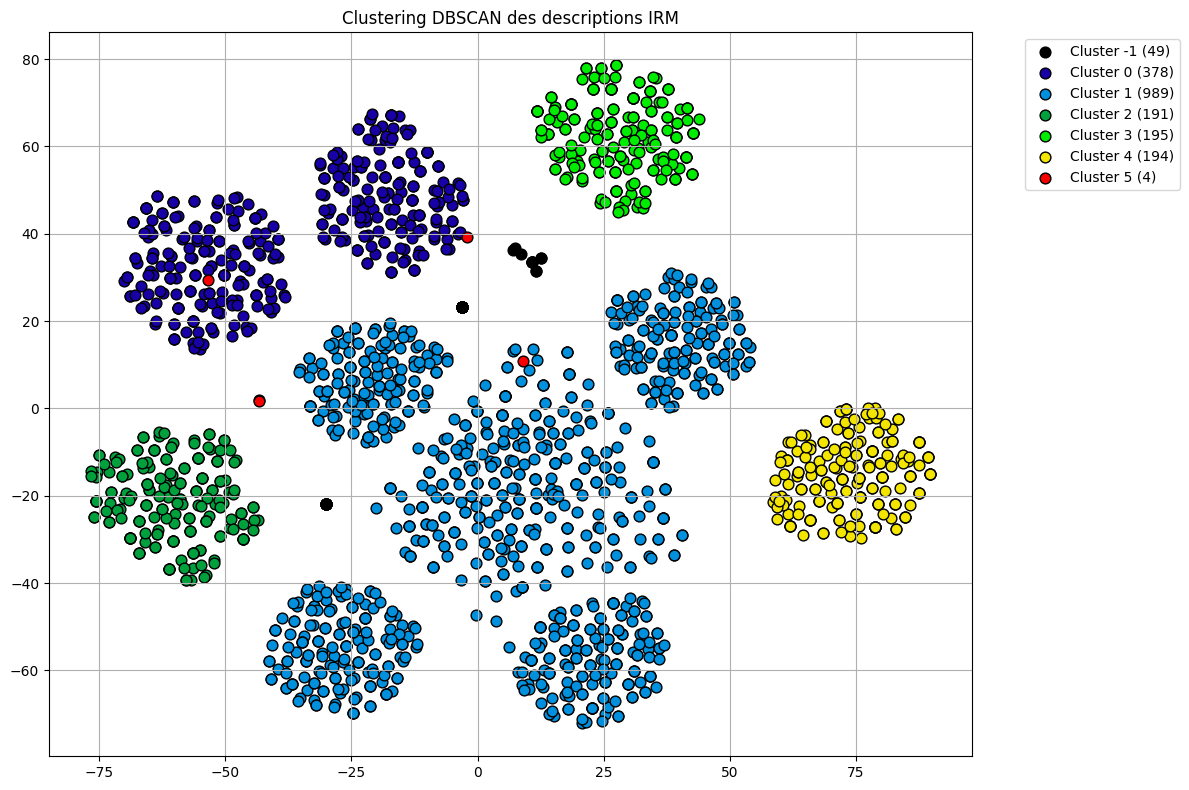


--- Cluster contenant nos 3 valeurs ---


107     Coupes CISSOR d'Edward aux Mains d'Argent
108          Coupe DWI JAUNE PIPI de Donald TRUMP
115                 Étude FLAIR du Pelvis Presley
1950                                 Blade Runner
Name: description_irm, dtype: object

In [358]:
# Réassignation à un cluster spécial
adjusted_labels = cluster_labels.copy()
new_cluster_id = max(adjusted_labels) + 1
for i in indices_recuperables:
    adjusted_labels[i] = new_cluster_id


# Visualisation
unique_labels, counts = np.unique(adjusted_labels, return_counts=True)
cmap = matplotlib.colormaps.get_cmap('nipy_spectral')
colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

plt.figure(figsize=(12, 8))
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    mask = adjusted_labels == label
    plt.scatter(coords_2d[mask, 0], coords_2d[mask, 1],
                c=[colors[i]], label=f"Cluster {label} ({count})",
                s=60, edgecolor='k')

plt.title("Clustering DBSCAN des descriptions IRM")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Affichons les points du nouveau cluster
bruit_final = data.iloc[np.where(adjusted_labels == 5)[0]]
print("\n--- Cluster contenant nos 3 valeurs ---")
display(bruit_final["description_irm"])


En fixant le seuil à 0.91, on remarque qu'un des outliers a été clusterisé : Blade Runner ! On se retrouve avec un cluster de 4 valeurs au lieu de 3.

Pourquoi ? Si on regarde à nouveau les distances ci-dessus, on peut voir que "Blade Runner" a une distance min de 0.756.

Comment ça se fait ? Si on regarde notre dataset, on a 371 descriptions contenant le mot "BLADE"... 😁

Dans ce cas précis, si on veut avoir une certaine tolérance pour clusteriser "Coupes CISSOR d'Edward aux Mains d'Argent" qui est tout de même très éloigné (0.90), on doit accepter que "Blade Runner" qui est plus proche le soit également.

Il y a peut-être une solution. A creuser.